## 0. Import relevant libraries

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import random as rd
import pickle

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from csaps import csaps

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


## 1. Import features data

In [2]:
" Import data as Python pandas DataFrame "

LOC_STR = '/Users/arijitchakraborty/Desktop/Zeolite w:TAMU/complete_data_avail.xlsx'
_DATA_ = pd.read_excel(LOC_STR, sheet_name=0, header=0, index_col='name')
            
_DATA = _DATA_[['density', 'spg', 'volume', 'pld', 'lcd', 'void_frac', 'surf_area_m2g',
       'surf_area_m2cm3', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac', 'largest_free_sphere',
       'largest_included_sphere', 'largest_included_sphere_free']]


## 2. Import output variables' data

In [24]:
# CO2_OG_LOC_STR = '/Users/arijitchakraborty/Desktop/Zeolite w:TAMU/CO2.xlsx'
CO2_LOC_STR = "/Users/arijitchakraborty/Desktop/Zeolite w:TAMU/0_interpolated_data_indiv_200pts/interpolated_data_indiv_T_single_site_models.xlsx"

CO2_xl = pd.ExcelFile(CO2_LOC_STR)
len(CO2_xl.sheet_names)  # sheet names


194

## 3. Obtain common adsorbents

In [25]:
_COMMON_ADSORBENTS = list(set(CO2_xl.sheet_names).intersection(_DATA.index))
print('There are ' + str(len(_COMMON_ADSORBENTS)) + ' common adsorbents.')


There are 188 common adsorbents.


### 3.1 Reindex based on common adsorbents

In [26]:
_DATA_REINDEXED = _DATA.reindex(_COMMON_ADSORBENTS)

print('Shape of the inputs is: ', _DATA_REINDEXED.shape)


Shape of the inputs is:  (188, 16)


## 4. Shuffle the adsorbents. Then split into train & test adsorbents

This is done based on cleaned outputs + inputs

### 4.1 Shuffle the adsorbents

In [27]:
print('There are ' + str(len(_COMMON_ADSORBENTS)) + ' adsorbents.')

rd.shuffle(_COMMON_ADSORBENTS)


There are 188 adsorbents.


### 4.2 Decide Train & Test adsorbents


In [28]:
_TRAIN_TEST_SPLIT_PERCENT_ = 80/100
_TRAIN_TEST_SPLIT_INDEX_ = int(_TRAIN_TEST_SPLIT_PERCENT_ * len(_COMMON_ADSORBENTS))

TRAIN_ADSORBENTS = _COMMON_ADSORBENTS[:_TRAIN_TEST_SPLIT_INDEX_]
TEST_ADSORBENTS = _COMMON_ADSORBENTS[_TRAIN_TEST_SPLIT_INDEX_:]


#### 4.3.1 Create inputs + outputs DataFrames for Train adsorbents

In [ ]:
CO2_DataFrame_dict_TRAIN = dict.fromkeys(TRAIN_ADSORBENTS)

fig, axs = plt.subplots(len(TRAIN_ADSORBENTS), 3, figsize=(10, 400))
fig.tight_layout()

row_counter = 0; column_counter = 0
TEMP_VALS = ['298 K', '323 K', '373 K']

for ADSORBENT in TRAIN_ADSORBENTS:
            
    _temp_CO2_DataFrame_ = pd.read_excel(CO2_LOC_STR, sheet_name=ADSORBENT, names=['Temperature (K)',
    'Pressure (Pa)', 'Absolute Loading (mol/kg)'], header=None, skiprows = range(1))
    
    UniqueTemps = _temp_CO2_DataFrame_['Temperature (K)'].unique().tolist()[::]
    
    CO2_DataFrame_dict_TRAIN[ADSORBENT] = dict.fromkeys(UniqueTemps)
    
    _temp_CO2_DataFrame_[[_DATA_REINDEXED.loc[ADSORBENT].index]] = pd.DataFrame(_DATA_REINDEXED.loc[ADSORBENT])
    
    for Temp, Temp_index in zip(UniqueTemps, range(len(UniqueTemps))):
                
        CO2_DataFrame_dict_TRAIN[ADSORBENT][Temp] = tuple(_temp_CO2_DataFrame_.groupby('Temperature (K)'))[Temp_index][1]
        
        temp_first_row = CO2_DataFrame_dict_TRAIN[ADSORBENT][Temp].iloc[0, :].copy(deep=True)
        
        x = CO2_DataFrame_dict_TRAIN[ADSORBENT][Temp]['Pressure (Pa)']
        y = CO2_DataFrame_dict_TRAIN[ADSORBENT][Temp]['Absolute Loading (mol/kg)']
        
        if np.any((x > 2e6) & (x < 6e6)):

            axs[row_counter, column_counter].scatter(x, y, c='k')
            axs[row_counter, column_counter].set_title(ADSORBENT + ' – ' + TEMP_VALS[column_counter])

            if len(x) > 4:
                # Repeat the values N times
                N = 200; NUM_IGNORED_VALS = 5;
                repeated_values = np.tile(temp_first_row, N)
                # Reshape the repeated values into a Nx19 array
                reshaped_values = np.reshape(repeated_values, (N, 19))
                # Create a DataFrame with the repeated rows
                CO2_DataFrame_dict_TRAIN[ADSORBENT][Temp] = pd.DataFrame(reshaped_values, columns=[
                    'Temperature (K)', 'Pressure (Pa)', 'Absolute Loading (mol/kg)', 'density', 'spg', 'volume',
                    'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3', 'ASA', 'AV', 'NASA', 'NAV',
                    'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free'])
                
                xi = np.linspace(min(x), max(x), int(N + NUM_IGNORED_VALS))
                yi = csaps(x, y, xi, smooth=1); yi[0] = 0
                axs[row_counter, column_counter].plot(xi[:-NUM_IGNORED_VALS], yi[:-NUM_IGNORED_VALS], 'r-')
                
                CO2_DataFrame_dict_TRAIN[ADSORBENT][Temp]['Pressure (Pa)'] = xi[:-NUM_IGNORED_VALS]
                CO2_DataFrame_dict_TRAIN[ADSORBENT][Temp]['Absolute Loading (mol/kg)'] = yi[:-NUM_IGNORED_VALS]
            else:
                pass
        
        else:
            pass

        column_counter += 1
    
    column_counter = 0
    row_counter += 1


#### 4.3.2 Create inputs + outputs DataFrames for Test adsorbents

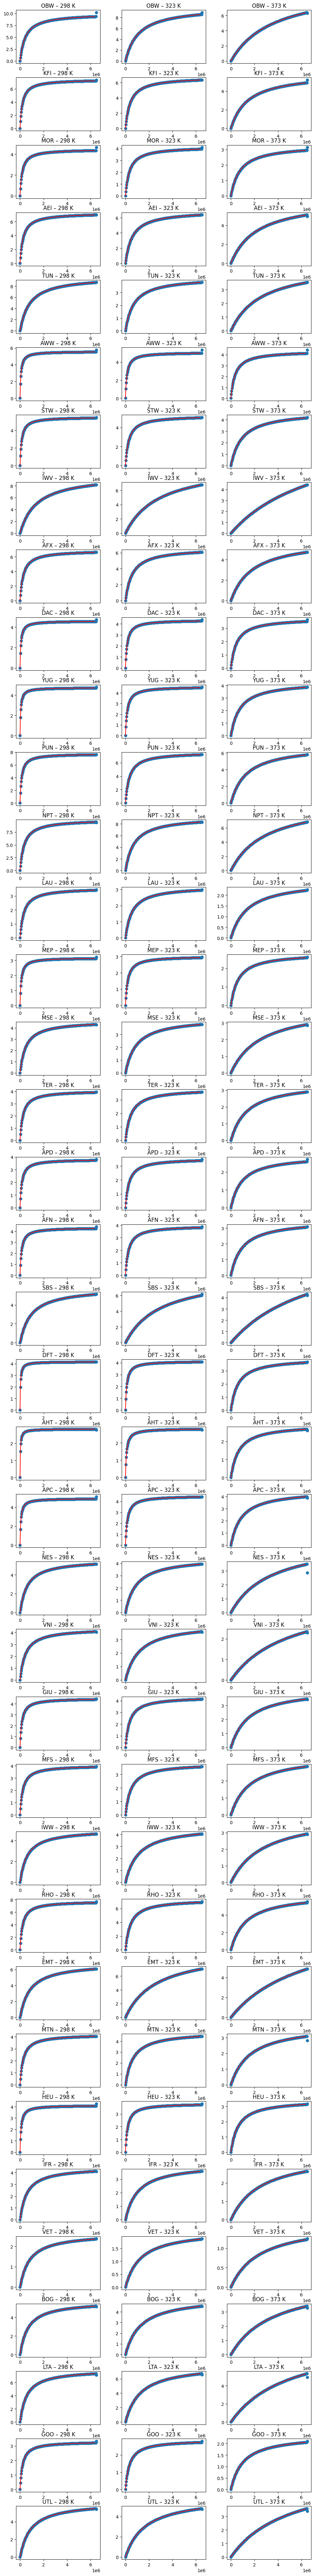

In [43]:
CO2_DataFrame_dict_TEST = dict.fromkeys(TEST_ADSORBENTS)

fig, axs = plt.subplots(len(TEST_ADSORBENTS), 3, figsize=(10, 80))
fig.tight_layout()

row_counter = 0; column_counter = 0
TEMP_VALS = ['298 K', '323 K', '373 K']

for ADSORBENT in TEST_ADSORBENTS:
        
    _temp_CO2_DataFrame_ = pd.read_excel(CO2_LOC_STR, sheet_name=ADSORBENT, names=['Temperature (K)',
    'Pressure (Pa)', 'Absolute Loading (mol/kg)'], header=None, skiprows = range(1))
    
    UniqueTemps = _temp_CO2_DataFrame_['Temperature (K)'].unique().tolist()[::]
    
    CO2_DataFrame_dict_TEST[ADSORBENT] = dict.fromkeys(UniqueTemps)
    
    _temp_CO2_DataFrame_[[_DATA_REINDEXED.loc[ADSORBENT].index]] = pd.DataFrame(_DATA_REINDEXED.loc[ADSORBENT])
    
    for Temp, Temp_index in zip(UniqueTemps, range(len(UniqueTemps))):
                
        CO2_DataFrame_dict_TEST[ADSORBENT][Temp] = tuple(_temp_CO2_DataFrame_.groupby('Temperature (K)'))[Temp_index][1]
        
        temp_first_row = CO2_DataFrame_dict_TEST[ADSORBENT][Temp].iloc[0, :].copy(deep=True)
        
        x = CO2_DataFrame_dict_TEST[ADSORBENT][Temp]['Pressure (Pa)']
        y = CO2_DataFrame_dict_TEST[ADSORBENT][Temp]['Absolute Loading (mol/kg)']
        
        if np.any((x > 2e6) & (x < 6e6)):

            axs[row_counter, column_counter].plot(x, y, 'o')
            axs[row_counter, column_counter].set_title(ADSORBENT + ' – ' + TEMP_VALS[column_counter])

            if len(x) > 4:
                # Repeat the values N times
                N = 200; NUM_IGNORED_VALS = 5;
                repeated_values = np.tile(temp_first_row, N)
                # Reshape the repeated values into a Nx19 array
                reshaped_values = np.reshape(repeated_values, (N, 19))
                # Create a DataFrame with the repeated rows
                CO2_DataFrame_dict_TEST[ADSORBENT][Temp] = pd.DataFrame(reshaped_values, columns=[
                    'Temperature (K)', 'Pressure (Pa)', 'Absolute Loading (mol/kg)', 'density', 'spg', 'volume',
                    'pld', 'lcd', 'void_frac', 'surf_area_m2g', 'surf_area_m2cm3', 'ASA', 'AV', 'NASA', 'NAV',
                    'VolFrac', 'largest_free_sphere', 'largest_included_sphere', 'largest_included_sphere_free'])
                
                xi = np.linspace(min(x), max(x), N + NUM_IGNORED_VALS)
                yi = csaps(x, y, xi, smooth=1); yi[0] = 0
                axs[row_counter, column_counter].plot(xi[:-NUM_IGNORED_VALS], yi[:-NUM_IGNORED_VALS], 'r-')
                
                CO2_DataFrame_dict_TEST[ADSORBENT][Temp]['Pressure (Pa)'] = xi[:-NUM_IGNORED_VALS]
                CO2_DataFrame_dict_TEST[ADSORBENT][Temp]['Absolute Loading (mol/kg)'] = yi[:-NUM_IGNORED_VALS]
            else:
                pass
        
        else:
            pass

        column_counter += 1
    
    column_counter = 0
    row_counter += 1
        

## 5. Combine DataFrames

### 5.1 First, for train adsorbents

In [44]:
dframes_298_train = []
dframes_323_train = []
dframes_373_train = []

for ADSORBENT in TRAIN_ADSORBENTS:
    
    try:
        dframes_298_train.append(CO2_DataFrame_dict_TRAIN[ADSORBENT][298])
    except:
        print('298 K not available for ', ADSORBENT)
    
    try:
        dframes_323_train.append(CO2_DataFrame_dict_TRAIN[ADSORBENT][323])
    except:
        print('323 K not available for ', ADSORBENT)
    
    try:
        dframes_373_train.append(CO2_DataFrame_dict_TRAIN[ADSORBENT][373])
    except:
        print('373 K not available for ', ADSORBENT)
    

In [45]:
DF298K_train = pd.concat(dframes_298_train)
DF323K_train = pd.concat(dframes_323_train)
DF373K_train = pd.concat(dframes_373_train)


In [46]:
DF323K_train.head()

,Temperature (K),Pressure (Pa),Absolute Loading (mol/kg),density,spg,volume,pld,lcd,void_frac,surf_area_m2g,surf_area_m2cm3,ASA,AV,NASA,NAV,VolFrac,largest_free_sphere,largest_included_sphere,largest_included_sphere_free
0,323.0,0.000000,0.000000,1.754532,74.0,18.955164,2.88024,3.60282,0.208281,0.0,0.0,0.0,0.01222,0.0,0.0,0.02144,3.10046,3.61163,3.61163
1,323.0,31862.745098,0.696355,1.754532,74.0,18.955164,2.88024,3.60282,0.208281,0.0,0.0,0.0,0.01222,0.0,0.0,0.02144,3.10046,3.61163,3.61163
2,323.0,63725.490196,1.236208,1.754532,74.0,18.955164,2.88024,3.60282,0.208281,0.0,0.0,0.0,0.01222,0.0,0.0,0.02144,3.10046,3.61163,3.61163
3,323.0,95588.235294,1.665337,1.754532,74.0,18.955164,2.88024,3.60282,0.208281,0.0,0.0,0.0,0.01222,0.0,0.0,0.02144,3.10046,3.61163,3.61163
4,323.0,127450.980392,2.015720,1.754532,74.0,18.955164,2.88024,3.60282,0.208281,0.0,0.0,0.0,0.01222,0.0,0.0,0.02144,3.10046,3.61163,3.61163


In [47]:
DF298K_train = DF298K_train.dropna(how='any', axis=0);
DF323K_train = DF323K_train.dropna(how='any', axis=0);
DF373K_train = DF373K_train.dropna(how='any', axis=0);


In [48]:
PRESSURE_THRESHOLD = 1e6

# selecting rows based on condition
DF298K_TRAIN_LOWP = DF298K_train[DF298K_train['Pressure (Pa)'] < PRESSURE_THRESHOLD]
DF298K_TRAIN_HIGHP = DF298K_train[DF298K_train['Pressure (Pa)'] >= PRESSURE_THRESHOLD]
DF323K_TRAIN_LOWP = DF323K_train[DF323K_train['Pressure (Pa)'] < PRESSURE_THRESHOLD]
DF323K_TRAIN_HIGHP = DF323K_train[DF323K_train['Pressure (Pa)'] >= PRESSURE_THRESHOLD]
DF373K_TRAIN_LOWP = DF373K_train[DF373K_train['Pressure (Pa)'] < PRESSURE_THRESHOLD]
DF373K_TRAIN_HIGHP = DF373K_train[DF373K_train['Pressure (Pa)'] >= PRESSURE_THRESHOLD]


### 5.2 Next, for test adsorbents

In [49]:
dframes_298_test = []
dframes_323_test = []
dframes_373_test = []

for ADSORBENT in TEST_ADSORBENTS:
    
    try:
        dframes_298_test.append(CO2_DataFrame_dict_TEST[ADSORBENT][298])
    except:
        print('298 K not available for ', ADSORBENT)
    
    try:
        dframes_323_test.append(CO2_DataFrame_dict_TEST[ADSORBENT][323])
    except:
        print('323 K not available for ', ADSORBENT)
    
    try:
        dframes_373_test.append(CO2_DataFrame_dict_TEST[ADSORBENT][373])
    except:
        print('373 K not available for ', ADSORBENT)
    

In [50]:
DF298K_test = pd.concat(dframes_298_test)
DF323K_test = pd.concat(dframes_323_test)
DF373K_test = pd.concat(dframes_373_test)


In [51]:
DF298K_test.head()

,Temperature (K),Pressure (Pa),Absolute Loading (mol/kg),density,spg,volume,pld,lcd,void_frac,surf_area_m2g,surf_area_m2cm3,ASA,AV,NASA,NAV,VolFrac,largest_free_sphere,largest_included_sphere,largest_included_sphere_free
0,298.0,0.000000,0.000000,1.26984,139.0,26.190262,4.53952,8.61139,0.462373,919.4,1167.48,886.309,0.151469,189.415,0.0,0.19234,4.78303,8.8607,8.8607
1,298.0,31862.745098,0.663713,1.26984,139.0,26.190262,4.53952,8.61139,0.462373,919.4,1167.48,886.309,0.151469,189.415,0.0,0.19234,4.78303,8.8607,8.8607
2,298.0,63725.490196,1.245289,1.26984,139.0,26.190262,4.53952,8.61139,0.462373,919.4,1167.48,886.309,0.151469,189.415,0.0,0.19234,4.78303,8.8607,8.8607
3,298.0,95588.235294,1.758242,1.26984,139.0,26.190262,4.53952,8.61139,0.462373,919.4,1167.48,886.309,0.151469,189.415,0.0,0.19234,4.78303,8.8607,8.8607
4,298.0,127450.980392,2.214608,1.26984,139.0,26.190262,4.53952,8.61139,0.462373,919.4,1167.48,886.309,0.151469,189.415,0.0,0.19234,4.78303,8.8607,8.8607


In [52]:
DF298K_test = DF298K_test.dropna(how='any',axis=0);
DF323K_test = DF323K_test.dropna(how='any',axis=0);
DF373K_test = DF373K_test.dropna(how='any',axis=0);


In [53]:
# selecting rows based on condition
DF298K_TEST_LOWP = DF298K_test[DF298K_test['Pressure (Pa)'] < PRESSURE_THRESHOLD]
DF298K_TEST_HIGHP = DF298K_test[DF298K_test['Pressure (Pa)'] >= PRESSURE_THRESHOLD]
DF323K_TEST_LOWP = DF323K_test[DF323K_test['Pressure (Pa)'] < PRESSURE_THRESHOLD]
DF323K_TEST_HIGHP = DF323K_test[DF323K_test['Pressure (Pa)'] >= PRESSURE_THRESHOLD]
DF373K_TEST_LOWP = DF373K_test[DF373K_test['Pressure (Pa)'] < PRESSURE_THRESHOLD]
DF373K_TEST_HIGHP = DF373K_test[DF373K_test['Pressure (Pa)'] >= PRESSURE_THRESHOLD]


# Sidetrack: Let's split on the basis of pressures – low & high

First, low P at 323 K


In [ ]:
X_TRAIN_323K_LOWP = DF323K_TRAIN_LOWP.loc[:, DF323K_TRAIN_LOWP.columns != 'Absolute Loading (mol/kg)'].to_numpy()[:,1:]
X_TEST_323K_LOWP = DF323K_TEST_LOWP.loc[:, DF323K_TEST_LOWP.columns != 'Absolute Loading (mol/kg)'].to_numpy()[:,1:]


In [ ]:
Y_TRAIN_323K_LOWP = DF323K_TRAIN_LOWP.loc[:, 'Absolute Loading (mol/kg)'].to_numpy().reshape(-1, 1)
Y_TEST_323K_LOWP = DF323K_TEST_LOWP.loc[:, 'Absolute Loading (mol/kg)'].to_numpy().reshape(-1, 1)


In [ ]:
Y_TRAIN_323K_LOWP = np.delete(Y_TRAIN_323K_LOWP, np.unique(np.argwhere(np.isnan(X_TRAIN_323K_LOWP))[:, 0]), axis=0)
Y_TEST_323K_LOWP = np.delete(Y_TEST_323K_LOWP, np.unique(np.argwhere(np.isnan(X_TEST_323K_LOWP))[:, 0]), axis=0)
X_TRAIN_323K_LOWP = np.delete(X_TRAIN_323K_LOWP, np.unique(np.argwhere(np.isnan(X_TRAIN_323K_LOWP))[:, 0]), axis=0)
X_TEST_323K_LOWP = np.delete(X_TEST_323K_LOWP, np.unique(np.argwhere(np.isnan(X_TEST_323K_LOWP))[:, 0]), axis=0)


Now, high P at 323 K

In [ ]:
X_TRAIN_323K_HIGHP = DF323K_TRAIN_HIGHP.loc[:, DF323K_TRAIN_HIGHP.columns != 'Absolute Loading (mol/kg)'].to_numpy()[:,1:]
X_TEST_323K_HIGHP = DF323K_TEST_HIGHP.loc[:, DF323K_TEST_HIGHP.columns != 'Absolute Loading (mol/kg)'].to_numpy()[:,1:]


In [ ]:
Y_TRAIN_323K_HIGHP = DF323K_TRAIN_HIGHP.loc[:, 'Absolute Loading (mol/kg)'].to_numpy().reshape(-1, 1)
Y_TEST_323K_HIGHP = DF323K_TEST_HIGHP.loc[:, 'Absolute Loading (mol/kg)'].to_numpy().reshape(-1, 1)


In [ ]:
Y_TRAIN_323K_HIGHP = np.delete(Y_TRAIN_323K_HIGHP, np.unique(np.argwhere(np.isnan(X_TRAIN_323K_HIGHP))[:, 0]), axis=0)
Y_TEST_323K_HIGHP = np.delete(Y_TEST_323K_HIGHP, np.unique(np.argwhere(np.isnan(X_TEST_323K_HIGHP))[:, 0]), axis=0)
X_TRAIN_323K_HIGHP = np.delete(X_TRAIN_323K_HIGHP, np.unique(np.argwhere(np.isnan(X_TRAIN_323K_HIGHP))[:, 0]), axis=0)
X_TEST_323K_HIGHP = np.delete(X_TEST_323K_HIGHP, np.unique(np.argwhere(np.isnan(X_TEST_323K_HIGHP))[:, 0]), axis=0)


Let's save these, and test on AI-DARWIN

In [ ]:
with open('TRAIN_323K_LOWHIGH.npy', 'wb') as TRAIN_FILE:
    np.save(TRAIN_FILE, np.array(TRAIN_ADSORBENTS))
#     np.save(TRAIN_FILE, X_TRAIN_298K)
#     np.save(TRAIN_FILE, Y_TRAIN_298K)
    np.save(TRAIN_FILE, X_TRAIN_323K_LOWP)
    np.save(TRAIN_FILE, Y_TRAIN_323K_LOWP)
    np.save(TRAIN_FILE, X_TRAIN_323K_HIGHP)
    np.save(TRAIN_FILE, Y_TRAIN_323K_HIGHP)
#     np.save(TRAIN_FILE, X_TRAIN_373K)
#     np.save(TRAIN_FILE, Y_TRAIN_373K)

with open('TEST_323K_LOWHIGH.npy', 'wb') as TEST_FILE:
    np.save(TEST_FILE, np.array(TEST_ADSORBENTS))
#     np.save(TEST_FILE, X_TEST_298K)
#     np.save(TEST_FILE, Y_TEST_298K)
    np.save(TEST_FILE, X_TEST_323K_LOWP)
    np.save(TEST_FILE, Y_TEST_323K_LOWP)
    np.save(TEST_FILE, X_TEST_323K_HIGHP)
    np.save(TEST_FILE, Y_TEST_323K_HIGHP)
#     np.save(TEST_FILE, X_TEST_373K)
#     np.save(TEST_FILE, Y_TEST_373K)

In [ ]:
Y_TEST_323K_HIGHP.shape

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit(X_TRAIN_323K_LOWP[:,1:])

In [ ]:
print(pca.explained_variance_ratio_)

In [ ]:
DF323K_train.iloc[:,1:]

## 6. Create Train & Test Splits for AI-DARWIN

### 6.1 For 298 K

In [54]:
X_TRAIN_298K = DF298K_train.loc[:, DF298K_train.columns != 'Absolute Loading (mol/kg)'].to_numpy(dtype='float64')[:,1:]
X_TEST_298K = DF298K_test.loc[:, DF298K_test.columns != 'Absolute Loading (mol/kg)'].to_numpy(dtype='float64')[:,1:]

print(X_TRAIN_298K.shape)
print(X_TEST_298K.shape)


(29000, 17)
(7600, 17)


In [55]:
print(np.any(np.isnan(X_TRAIN_298K)))
print(np.any(np.isnan(X_TEST_298K)))


False
False


In [56]:
# DF298K_train.isnull().values.any()
# DF298K_train.isnull().sum()


In [57]:
Y_TRAIN_298K = DF298K_train.loc[:, 'Absolute Loading (mol/kg)'].to_numpy().reshape(-1, 1)
Y_TEST_298K = DF298K_test.loc[:, 'Absolute Loading (mol/kg)'].to_numpy().reshape(-1, 1)

print(Y_TRAIN_298K.shape)
print(Y_TEST_298K.shape)


(29000, 1)
(7600, 1)


Delete NaN's

In [58]:
Y_TRAIN_298K = np.delete(Y_TRAIN_298K, np.unique(np.argwhere(np.isnan(X_TRAIN_298K))[:, 0]), axis=0)
Y_TEST_298K = np.delete(Y_TEST_298K, np.unique(np.argwhere(np.isnan(X_TEST_298K))[:, 0]), axis=0)
X_TRAIN_298K = np.delete(X_TRAIN_298K, np.unique(np.argwhere(np.isnan(X_TRAIN_298K))[:, 0]), axis=0)
X_TEST_298K = np.delete(X_TEST_298K, np.unique(np.argwhere(np.isnan(X_TEST_298K))[:, 0]), axis=0)


In [59]:
print(Y_TRAIN_298K.shape)
print(Y_TEST_298K.shape)


(29000, 1)
(7600, 1)


### 6.2 For 323 K

In [60]:
X_TRAIN_323K = DF323K_train.loc[:, DF323K_train.columns != 'Absolute Loading (mol/kg)'].to_numpy()[:,1:]
X_TEST_323K = DF323K_test.loc[:, DF323K_test.columns != 'Absolute Loading (mol/kg)'].to_numpy()[:,1:]

print(X_TRAIN_323K.shape)
print(X_TEST_323K.shape)


(29000, 17)
(7600, 17)


In [62]:
print(np.any(np.isnan(X_TRAIN_323K)))
print(np.any(np.isnan(X_TEST_323K)))


False
False


In [63]:
Y_TRAIN_323K = DF323K_train.loc[:, 'Absolute Loading (mol/kg)'].to_numpy().reshape(-1, 1)
Y_TEST_323K = DF323K_test.loc[:, 'Absolute Loading (mol/kg)'].to_numpy().reshape(-1, 1)

print(Y_TRAIN_323K.shape)
print(Y_TEST_323K.shape)


(29000, 1)
(7600, 1)


In [64]:
DF323K_train.columns

Index(['Temperature (K)', 'Pressure (Pa)', 'Absolute Loading (mol/kg)',
       'density', 'spg', 'volume', 'pld', 'lcd', 'void_frac', 'surf_area_m2g',
       'surf_area_m2cm3', 'ASA', 'AV', 'NASA', 'NAV', 'VolFrac',
       'largest_free_sphere', 'largest_included_sphere',
       'largest_included_sphere_free'],
      dtype='object')

Delete NaN's

In [65]:
Y_TRAIN_323K = np.delete(Y_TRAIN_323K, np.unique(np.argwhere(np.isnan(X_TRAIN_323K))[:, 0]), axis=0)
Y_TEST_323K = np.delete(Y_TEST_323K, np.unique(np.argwhere(np.isnan(X_TEST_323K))[:, 0]), axis=0)
X_TRAIN_323K = np.delete(X_TRAIN_323K, np.unique(np.argwhere(np.isnan(X_TRAIN_323K))[:, 0]), axis=0)
X_TEST_323K = np.delete(X_TEST_323K, np.unique(np.argwhere(np.isnan(X_TEST_323K))[:, 0]), axis=0)


In [66]:
print(Y_TRAIN_323K.shape)
print(Y_TEST_323K.shape)


(29000, 1)
(7600, 1)


### 6.3 For 373 K

In [67]:
X_TRAIN_373K = DF373K_train.loc[:, DF373K_train.columns != 'Absolute Loading (mol/kg)'].to_numpy()[:,1:]
X_TEST_373K = DF373K_test.loc[:, DF373K_test.columns != 'Absolute Loading (mol/kg)'].to_numpy()[:,1:]

print(X_TRAIN_373K.shape)
print(X_TEST_373K.shape)


(29000, 17)
(7600, 17)


In [75]:
DF373K_train.loc[:, DF373K_train.columns != 'Absolute Loading (mol/kg)']

,Temperature (K),Pressure (Pa),density,spg,volume,pld,lcd,void_frac,surf_area_m2g,surf_area_m2cm3,ASA,AV,NASA,NAV,VolFrac,largest_free_sphere,largest_included_sphere,largest_included_sphere_free
0,373.0,0.000000e+00,1.754532,74.0,18.955164,2.88024,3.60282,0.208281,0.000,0.000,0.000,0.012220,0.0,0.0,0.02144,3.10046,3.61163,3.61163
1,373.0,3.186275e+04,1.754532,74.0,18.955164,2.88024,3.60282,0.208281,0.000,0.000,0.000,0.012220,0.0,0.0,0.02144,3.10046,3.61163,3.61163
2,373.0,6.372549e+04,1.754532,74.0,18.955164,2.88024,3.60282,0.208281,0.000,0.000,0.000,0.012220,0.0,0.0,0.02144,3.10046,3.61163,3.61163
3,373.0,9.558824e+04,1.754532,74.0,18.955164,2.88024,3.60282,0.208281,0.000,0.000,0.000,0.012220,0.0,0.0,0.02144,3.10046,3.61163,3.61163
4,373.0,1.274510e+05,1.754532,74.0,18.955164,2.88024,3.60282,0.208281,0.000,0.000,0.000,0.012220,0.0,0.0,0.02144,3.10046,3.61163,3.61163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,373.0,6.213235e+06,1.780506,11.0,18.678643,4.70142,6.95807,0.326554,468.913,834.899,495.333,0.065813,0.0,0.0,0.11718,4.93842,7.09171,6.78466
196,373.0,6.245098e+06,1.780506,11.0,18.678643,4.70142,6.95807,0.326554,468.913,834.899,495.333,0.065813,0.0,0.0,0.11718,4.93842,7.09171,6.78466
197,373.0,6.276961e+06,1.780506,11.0,18.678643,4.70142,6.95807,0.326554,468.913,834.899,495.333,0.065813,0.0,0.0,0.11718,4.93842,7.09171,6.78466
198,373.0,6.308824e+06,1.780506,11.0,18.678643,4.70142,6.95807,0.326554,468.913,834.899,495.333,0.065813,0.0,0.0,0.11718,4.93842,7.09171,6.78466


In [68]:
print(np.any(np.isnan(X_TRAIN_373K)))
print(np.any(np.isnan(X_TEST_373K)))


False
False


In [69]:
Y_TRAIN_373K = DF373K_train.loc[:, 'Absolute Loading (mol/kg)'].to_numpy().reshape(-1, 1)
Y_TEST_373K = DF373K_test.loc[:, 'Absolute Loading (mol/kg)'].to_numpy().reshape(-1, 1)

print(Y_TRAIN_373K.shape)
print(Y_TEST_373K.shape)


(29000, 1)
(7600, 1)


Delete NaN's

In [70]:
Y_TRAIN_373K = np.delete(Y_TRAIN_373K, np.unique(np.argwhere(np.isnan(X_TRAIN_373K))[:, 0]), axis=0)
Y_TEST_373K = np.delete(Y_TEST_373K, np.unique(np.argwhere(np.isnan(X_TEST_373K))[:, 0]), axis=0)
X_TRAIN_373K = np.delete(X_TRAIN_373K, np.unique(np.argwhere(np.isnan(X_TRAIN_373K))[:, 0]), axis=0)
X_TEST_373K = np.delete(X_TEST_373K, np.unique(np.argwhere(np.isnan(X_TEST_373K))[:, 0]), axis=0)


In [71]:
print(Y_TRAIN_373K.shape)
print(Y_TEST_373K.shape)


(29000, 1)
(7600, 1)


## Save the Numpy arrays into .npy files


In [72]:
with open('TRAIN.npy', 'wb') as TRAIN_FILE:
    np.save(TRAIN_FILE, np.array(TRAIN_ADSORBENTS))
    np.save(TRAIN_FILE, X_TRAIN_298K)
    np.save(TRAIN_FILE, Y_TRAIN_298K)
    np.save(TRAIN_FILE, X_TRAIN_323K)
    np.save(TRAIN_FILE, Y_TRAIN_323K)
    np.save(TRAIN_FILE, X_TRAIN_373K)
    np.save(TRAIN_FILE, Y_TRAIN_373K)

with open('TEST.npy', 'wb') as TEST_FILE:
    np.save(TEST_FILE, np.array(TEST_ADSORBENTS))
    np.save(TEST_FILE, X_TEST_298K)
    np.save(TEST_FILE, Y_TEST_298K)
    np.save(TEST_FILE, X_TEST_323K)
    np.save(TEST_FILE, Y_TEST_323K)
    np.save(TEST_FILE, X_TEST_373K)
    np.save(TEST_FILE, Y_TEST_373K)


## Load the data

Will only need to run this step in the future

In [301]:
with open('TRAIN.npy', 'rb') as TRAIN_FILE:
    TRAIN_ADSORBENTS = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_298K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_298K = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_323K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_323K = np.load(TRAIN_FILE, allow_pickle=True)
    X_TRAIN_373K = np.load(TRAIN_FILE, allow_pickle=True)
    Y_TRAIN_373K = np.load(TRAIN_FILE, allow_pickle=True)
    
with open('TEST.npy', 'rb') as TEST_FILE:
    TEST_ADSORBENTS = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_298K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_298K = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_323K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_323K = np.load(TEST_FILE, allow_pickle=True)
    X_TEST_373K = np.load(TEST_FILE, allow_pickle=True)
    Y_TEST_373K = np.load(TEST_FILE, allow_pickle=True)
    

## Evaluate results – 373K

In [302]:
with open('RESULTS_373.npy', 'rb') as RESULTS_FILE:
    X_train = np.load(RESULTS_FILE, allow_pickle=True)
    X_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred = np.load(RESULTS_FILE, allow_pickle=True)
    y_train = np.load(RESULTS_FILE, allow_pickle=True)
    y_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_train = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_test = np.load(RESULTS_FILE, allow_pickle=True)
    P_TRAIN_STD = np.load(RESULTS_FILE, allow_pickle=True)


Text(0.5, 0, 'Predicted Test')

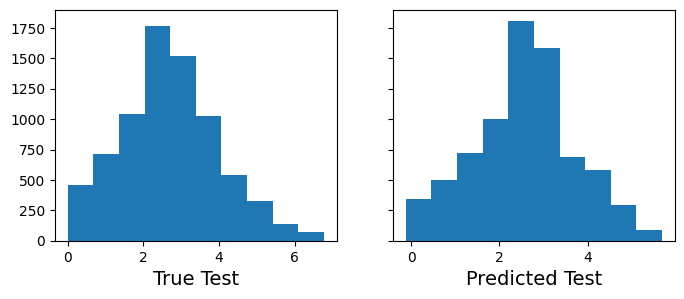

In [303]:
fig, ax = plt.subplots(1, 2, figsize=(8,3), sharey=True)
ax[0].hist(y_test)
ax[0].set_xlabel('True Test', fontsize=14)
ax[1].hist(Y_pred_test)
ax[1].set_xlabel('Predicted Test', fontsize=14)


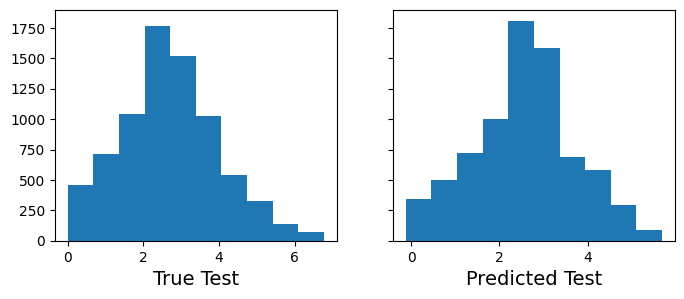

In [304]:
fig, ax = plt.subplots(1, 2, figsize=(8,3), sharey=True)
ax[0].hist(y_test)
ax[0].set_xlabel('True Test', fontsize=14)
ax[1].hist(Y_pred_test)
ax[1].set_xlabel('Predicted Test', fontsize=14)

X_TRAIN = X_TRAIN_373K[:, 1:]
X_TEST = X_TEST_373K[:, 1:]
TRAINx_temp_MEAN = np.mean(X_TRAIN, axis=0)
TRAINx_temp_STD = np.std(X_TRAIN, axis=0)

# Normalize the training inputs/features/indepedents
TRAINx_temp = (X_TRAIN - TRAINx_temp_MEAN) / TRAINx_temp_STD

# Normalize, based on the testing inputs/features/indepedents
TESTx_temp = (X_TEST - TRAINx_temp_MEAN) / TRAINx_temp_STD

# X = np.vstack((TRAINx_temp, TESTx_temp)).T
X = np.vstack((TRAINx_temp, TESTx_temp)).T
Y = np.vstack((Y_TRAIN_373K, Y_TEST_323K))

X_train = X.T[:X_TRAIN.shape[0], :]; y_train = Y[:X_TRAIN.shape[0]]
X_test = X.T[X_TRAIN.shape[0]:, :]; y_test = Y[X_TRAIN.shape[0]:]

P_TRAIN = X_TRAIN_373K[:, 0]#.reshape(-1, 1)
P_TRAIN_MEAN = np.mean(P_TRAIN)
P_TRAIN_STD = np.std(P_TRAIN)
P_TEST = X_TEST_373K[:, 0]#.reshape(-1, 1)
P = P_TEST/P_TRAIN_STD

In [305]:
def predict_for_zeolite_373(_P_, features):
    
    P = _P_/P_TRAIN_STD
    _MEAN_ = np.mean(X_TRAIN, axis=0)
    _STD_ = np.std(X_TRAIN, axis=0)
    
    normalized_features = (features - _MEAN_)/_STD_
    
    density = normalized_features[0]; spg = normalized_features[1]; volume = normalized_features[2];
    pld = normalized_features[3]; lcd = normalized_features[4]; void_frac = normalized_features[5];
    surf_area_m2g = normalized_features[6]; surf_area_m2cm3 = normalized_features[7];
    ASA = normalized_features[8]; AV = normalized_features[9]; NASA = normalized_features[10];
    NAV = normalized_features[11]; VolFrac = normalized_features[12];
    largest_free_sphere = normalized_features[13]; largest_included_sphere = normalized_features[14]
    largest_included_sphere_free = normalized_features[15]
    
    f1 = 1/((AV)**2)*np.exp(largest_included_sphere_free); beta1 = -0.3594413972218853
    f2 = ((lcd)**2)/np.exp(-surf_area_m2g)/np.exp(-volume); beta2 = 0.7236283377256563
    f3 = 1*np.exp(ASA)/np.exp(volume); beta3 = -2.491688880718375
    f4 = ((AV)**3)*((largest_included_sphere)**3)*1; beta4 = 0.09275076505414136
    f5 = np.exp(-largest_included_sphere_free)/((AV)**2)/np.exp(surf_area_m2cm3); beta5 = 0.9655176044485131
    f6 = 1/np.exp(VolFrac)*np.exp(void_frac); beta6 = 6.602116824421418
    f7 = (density)/np.exp(-largest_included_sphere_free)*((NASA)**3); beta7 = -8.506535242975505e-06
    f8 = 1*np.exp(spg)*np.exp(surf_area_m2g); beta8 = -1.613293940314934
    f9 = np.exp(spg)/np.exp(NAV)/np.exp(void_frac); beta9 = 1.275887158343305
    f10 = (NASA)*((ASA)**3)/np.exp(lcd); beta10 = -4.973935475022366e-06
    f11 = 1/np.exp(volume)/np.exp(AV); beta11 = -3.3528986757269825
    f12 = 1*np.exp(density)*np.exp(ASA); beta12 = 2.5511241106011875
    f13 = np.exp(largest_included_sphere)/(surf_area_m2g)*np.exp(-surf_area_m2g); beta13 = 0.00015360330426490517
    f14 = np.exp(-ASA)/np.exp(surf_area_m2g)/(largest_included_sphere_free); beta14 = -5.8135254289460757e-05
    intercept = 0
    theta = beta1*((f1*P)/(1 + f1*P)) + beta2*((f2*P)/(1 + f2*P)) + beta3*((f3*P)/(1 + f3*P)) + beta4*((f4*P)/(1 + f4*P)) + beta5*((f5*P)/(1 + f5*P)) + beta6*((f6*P)/(1 + f6*P)) + beta7*((f7*P)/(1 + f7*P)) + beta8*((f8*P)/(1 + f8*P)) + beta9*((f9*P)/(1 + f9*P)) + beta10*((f10*P)/(1 + f10*P)) + beta11*((f11*P)/(1 + f11*P)) + beta12*((f12*P)/(1 + f12*P)) + beta13*((f13*P)/(1 + f13*P)) + beta14*((f14*P)/(1 + f14*P))
    yt = theta + intercept
    
    return yt


Works.


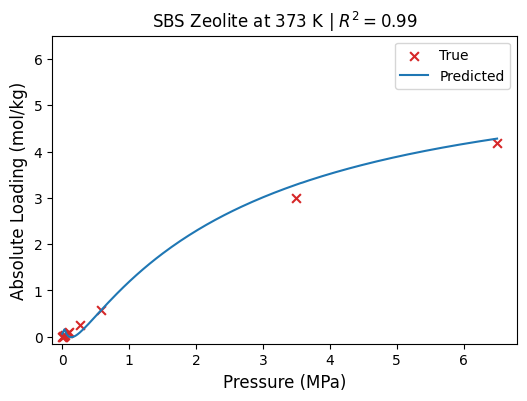

Works.


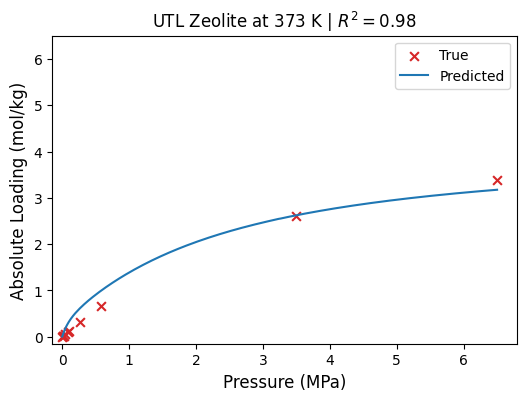

In [307]:
for _test_z_ in ['SBS', 'UTL']:
    
#     try:
    plt.figure(figsize=(6,4), dpi=100)

    CO2_OG_LOC_STR = '/Users/arijitchakraborty/Desktop/Zeolite w:TAMU/CO2.xlsx'
    CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_test_z_)

    plt.scatter(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373]['Pressure (Pa)']/1e6,
               CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373]['Absolute Loading (mol/kg)'],
                       c='tab:red', label='True', marker='x', s=40)

    min_p = min(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373]['Pressure (Pa)'])
    max_p = max(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373]['Pressure (Pa)'])
    p_range = np.linspace(min_p, max_p, 200)
    predictions = [predict_for_zeolite_373(p, list(_DATA_REINDEXED.loc[_test_z_])) for p in p_range]

    print('Works.')

    plt.plot(p_range/1e6, predictions, label='Predicted', c='tab:blue')
    plt.ylabel('Absolute Loading (mol/kg)', fontsize=12)
    plt.xlabel('Pressure (MPa)', fontsize=12)
    plt.title(r'{:s} Zeolite at 373 K | $R^{:d}={:.2f}$'.format(_test_z_,2, r2_score(
                CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==373][
                    'Absolute Loading (mol/kg)'], [predict_for_zeolite_373(p, list(
                        _DATA_REINDEXED.loc[_test_z_])) for p in CO2_temp_adsorbent_data[
                            CO2_temp_adsorbent_data['Temperature (K)']==373]['Pressure (Pa)']])))
    plt.ylim(-0.15,6.5)
    plt.xlim(-0.15, 6.8)
    plt.legend()
    plt.savefig('GOOD_TEST_{}_373K.png'.format(_test_z_), dpi=150)
    plt.show()
#     except:
#         print(_test_z_)


In [252]:
# First, for train
_train_preds_ = []
_train_real_ = []

for _ads_ in TRAIN_ADSORBENTS:
    
    CO2_OG_LOC_STR = '/Users/arijitchakraborty/Desktop/Zeolite w:TAMU/CO2.xlsx'
    CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_ads_)
    
    _train_real_.append(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                        'Temperature (K)']==373]['Absolute Loading (mol/kg)'].to_list())
    
    predictions = [predict_for_zeolite_373(p, list(_DATA_REINDEXED.loc[
                        _ads_])) for p in CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                                        'Temperature (K)']==373]['Pressure (Pa)']]
    
    _train_preds_.append(predictions)

def flatten_concatenation(matrix):
    flat_list = []
    for row in matrix:
        flat_list += row
    return flat_list

train_preds = np.array(flatten_concatenation(_train_preds_))
train_real = np.array(flatten_concatenation(_train_real_))

new_train_preds = np.delete(train_preds, np.argwhere(np.isnan(train_preds)))
new_train_real = np.delete(train_real, np.argwhere(np.isnan(train_preds)))


In [253]:
r2_score(new_train_real, new_train_preds)


0.8706730794649075

In [300]:
# Second, for test
_test_preds_ = []
_test_real_ = []

for _ads_ in TEST_ADSORBENTS:
    
    CO2_OG_LOC_STR = '/Users/arijitchakraborty/Desktop/Zeolite w:TAMU/CO2.xlsx'
    CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_ads_)
    
    _test_real_.append(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                        'Temperature (K)']==373]['Absolute Loading (mol/kg)'].to_list())
    
    predictions = [predict_for_zeolite_373(p, list(_DATA_REINDEXED.loc[
                        _ads_])) for p in CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                                        'Temperature (K)']==373]['Pressure (Pa)']]
    
    _test_preds_.append(predictions)

def flatten_concatenation(matrix):
    flat_list = []
    for row in matrix:
        flat_list += row
    return flat_list

test_preds = np.array(flatten_concatenation(_test_preds_))
test_real = np.array(flatten_concatenation(_test_real_))

new_test_preds = np.delete(test_preds, np.argwhere(np.isnan(test_preds)))
new_test_real = np.delete(test_real, np.argwhere(np.isnan(test_preds)))


In [257]:
r2_score(new_test_real, new_test_preds)


0.9388905708218312

Text(0.5, 0, 'WTF Predicted Test')

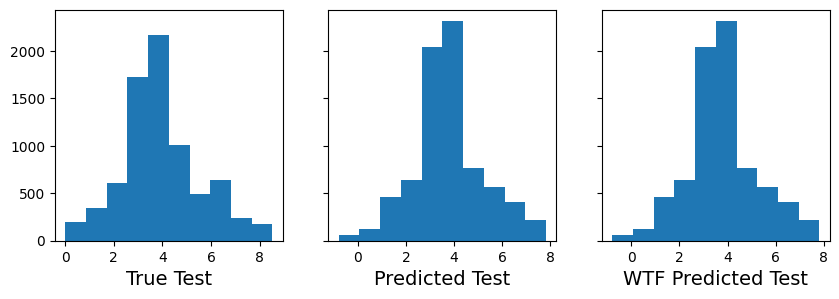

In [259]:
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
ax[0].hist(y_test)
ax[0].set_xlabel('True Test', fontsize=14)
ax[1].hist(Y_pred_test)
ax[1].set_xlabel('Predicted Test', fontsize=14)
ax[2].hist(yt)
ax[2].set_xlabel('WTF Predicted Test', fontsize=14)

## Evaluate Results – 323 K

In [260]:
with open('RESULTS_323.npy', 'rb') as RESULTS_FILE:
    
    X_train = np.load(RESULTS_FILE, allow_pickle=True)
    X_test = np.load(RESULTS_FILE, allow_pickle=True)
    
    Y = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred = np.load(RESULTS_FILE, allow_pickle=True)
    y_train = np.load(RESULTS_FILE, allow_pickle=True)
    y_test = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_train = np.load(RESULTS_FILE, allow_pickle=True)
    Y_pred_test = np.load(RESULTS_FILE, allow_pickle=True)
    P_TRAIN_STD = np.load(RESULTS_FILE, allow_pickle=True)


In [281]:
len(TRAIN_ADSORBENTS)

150

In [261]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

%matplotlib inline
import matplotlib.pyplot as plt


In [262]:
print(mean_absolute_error(Y, Y_pred))
print(r2_score(Y, Y_pred))


0.6675531487359067
0.6757596710201658


In [263]:
print(mean_absolute_error(y_train, Y_pred_train))
print(r2_score(y_train, Y_pred_train))


0.7346650189348584
0.6205215881663031


In [264]:
print(mean_absolute_error(y_test, Y_pred_test))
print(r2_score(y_test, Y_pred_test))


0.41146838087148535
0.8565027422391006


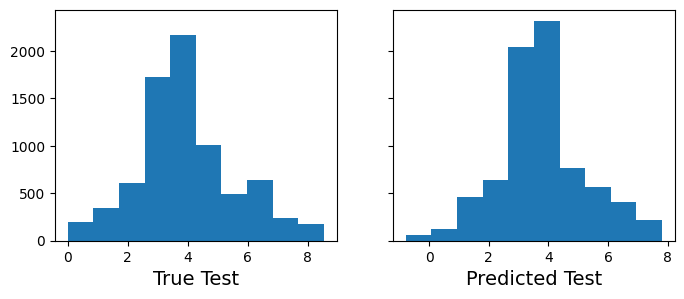

In [265]:
fig, ax = plt.subplots(1, 2, figsize=(8,3), sharey=True)
ax[0].hist(y_test)
ax[0].set_xlabel('True Test', fontsize=14)
ax[1].hist(Y_pred_test)
ax[1].set_xlabel('Predicted Test', fontsize=14)

X_TRAIN = X_TRAIN_323K[:, 1:]
X_TEST = X_TEST_323K[:, 1:]
TRAINx_temp_MEAN = np.mean(X_TRAIN, axis=0)
TRAINx_temp_STD = np.std(X_TRAIN, axis=0)

# Normalize the training inputs/features/indepedents
TRAINx_temp = (X_TRAIN - TRAINx_temp_MEAN) / TRAINx_temp_STD

# Normalize, based on the testing inputs/features/indepedents
TESTx_temp = (X_TEST - TRAINx_temp_MEAN) / TRAINx_temp_STD

# X = np.vstack((TRAINx_temp, TESTx_temp)).T
X = np.vstack((TRAINx_temp, TESTx_temp)).T
Y = np.vstack((Y_TRAIN_323K, Y_TEST_323K))

X_train = X.T[:X_TRAIN.shape[0], :]; y_train = Y[:X_TRAIN.shape[0]]
X_test = X.T[X_TRAIN.shape[0]:, :]; y_test = Y[X_TRAIN.shape[0]:]

P_TRAIN = X_TRAIN_323K[:, 0]#.reshape(-1, 1)
P_TRAIN_MEAN = np.mean(P_TRAIN)
P_TRAIN_STD = np.std(P_TRAIN)
P_TEST = X_TEST_323K[:, 0]#.reshape(-1, 1)
P = P_TEST/P_TRAIN_STD

In [266]:
density = X_test[:, 0]; spg = X_test[:, 1]; volume = X_test[:, 2]; pld = X_test[:, 3]; lcd = X_test[:, 4]
void_frac = X_test[:, 5]; surf_area_m2g = X_test[:, 6]; surf_area_m2cm3 = X_test[:, 7]; ASA = X_test[:, 8];
AV = X_test[:, 9]; NASA = X_test[:, 10]; NAV = X_test[:, 11]; VolFrac = X_test[:, 12];
largest_free_sphere = X_test[:, 13]; largest_included_sphere = X_test[:, 14]
largest_included_sphere_free = X_test[:, 15]


In [267]:
f1 = np.exp(-pld)*np.exp(-density)/((void_frac)**2); beta1 = 2.491214660055224
f2 = np.exp(-NASA)*np.exp(-NASA)/np.exp(largest_free_sphere); beta2 = -1.5263000635855446
f3 = 1/np.exp(-density)/((surf_area_m2g)**2); beta3 = -2.380734070171069
f4 = np.exp(-surf_area_m2cm3)/((AV)**3)*np.exp(void_frac); beta4 = -9.472686455629983e-06
f5 = np.exp(-largest_included_sphere_free)*np.exp(-pld)/((NAV)**2); beta5 = 2.7272349373873714
f6 = 1/np.exp(-largest_included_sphere_free)/((void_frac)**2); beta6 = -1.110269543429511
f7 = 1/np.exp(-VolFrac)/((NAV)**2); beta7 = 4.598133904458434
f8 = np.exp(ASA)/np.exp(-surf_area_m2g)/1; beta8 = 0.41918467042671564
f9 = np.exp(void_frac)/np.exp(-spg)*((NAV)**2); beta9 = 1.3561371522860057
f10 = ((NASA)**2)/np.exp(NASA)/((volume)**2); beta10 = 0.25063623373894434
f11 = np.exp(AV)/1/((surf_area_m2g)**2); beta11 = 2.3446256051528107
f12 = np.exp(-surf_area_m2cm3)*np.exp(pld)*np.exp(-NASA); beta12 = 1.4145370797433214
f13 = ((surf_area_m2cm3)**2)*np.exp(AV)*((lcd)**2); beta13 = 1.332332199550355
f14 = 1/np.exp(-surf_area_m2g)/((NAV)**2); beta14 = -5.517880398071334
intercept = 0
theta = beta1*((f1*P)/(1 + f1*P)) + beta2*((f2*P)/(1 + f2*P)) + beta3*((f3*P)/(1 + f3*P)) + beta4*((f4*P)/(1 + f4*P)) + beta5*((f5*P)/(1 + f5*P)) + beta6*((f6*P)/(1 + f6*P)) + beta7*((f7*P)/(1 + f7*P)) + beta8*((f8*P)/(1 + f8*P)) + beta9*((f9*P)/(1 + f9*P)) + beta10*((f10*P)/(1 + f10*P)) + beta11*((f11*P)/(1 + f11*P)) + beta12*((f12*P)/(1 + f12*P)) + beta13*((f13*P)/(1 + f13*P)) + beta14*((f14*P)/(1 + f14*P))
yt = theta + intercept


In [268]:
def predict_for_zeolite_323(_P_, features):
    
    P = _P_/P_TRAIN_STD
    _MEAN_ = np.mean(X_TRAIN, axis=0)
    _STD_ = np.std(X_TRAIN, axis=0)
    
    normalized_features = (features - _MEAN_)/_STD_
    
    density = normalized_features[0]; spg = normalized_features[1]; volume = normalized_features[2];
    pld = normalized_features[3]; lcd = normalized_features[4]; void_frac = normalized_features[5];
    surf_area_m2g = normalized_features[6]; surf_area_m2cm3 = normalized_features[7];
    ASA = normalized_features[8]; AV = normalized_features[9]; NASA = normalized_features[10];
    NAV = normalized_features[11]; VolFrac = normalized_features[12];
    largest_free_sphere = normalized_features[13]; largest_included_sphere = normalized_features[14]
    largest_included_sphere_free = normalized_features[15]
    
    f1 = np.exp(-pld)*np.exp(-density)/((void_frac)**2); beta1 = 2.491214660055224
    f2 = np.exp(-NASA)*np.exp(-NASA)/np.exp(largest_free_sphere); beta2 = -1.5263000635855446
    f3 = 1/np.exp(-density)/((surf_area_m2g)**2); beta3 = -2.380734070171069
    f4 = np.exp(-surf_area_m2cm3)/((AV)**3)*np.exp(void_frac); beta4 = -9.472686455629983e-06
    f5 = np.exp(-largest_included_sphere_free)*np.exp(-pld)/((NAV)**2); beta5 = 2.7272349373873714
    f6 = 1/np.exp(-largest_included_sphere_free)/((void_frac)**2); beta6 = -1.110269543429511
    f7 = 1/np.exp(-VolFrac)/((NAV)**2); beta7 = 4.598133904458434
    f8 = np.exp(ASA)/np.exp(-surf_area_m2g)/1; beta8 = 0.41918467042671564
    f9 = np.exp(void_frac)/np.exp(-spg)*((NAV)**2); beta9 = 1.3561371522860057
    f10 = ((NASA)**2)/np.exp(NASA)/((volume)**2); beta10 = 0.25063623373894434
    f11 = np.exp(AV)/1/((surf_area_m2g)**2); beta11 = 2.3446256051528107
    f12 = np.exp(-surf_area_m2cm3)*np.exp(pld)*np.exp(-NASA); beta12 = 1.4145370797433214
    f13 = ((surf_area_m2cm3)**2)*np.exp(AV)*((lcd)**2); beta13 = 1.332332199550355
    f14 = 1/np.exp(-surf_area_m2g)/((NAV)**2); beta14 = -5.517880398071334
    intercept = 0
    theta = beta1*((f1*P)/(1 + f1*P)) + beta2*((f2*P)/(1 + f2*P)) + beta3*((f3*P)/(1 + f3*P)) + beta4*((f4*P)/(1 + f4*P)) + beta5*((f5*P)/(1 + f5*P)) + beta6*((f6*P)/(1 + f6*P)) + beta7*((f7*P)/(1 + f7*P)) + beta8*((f8*P)/(1 + f8*P)) + beta9*((f9*P)/(1 + f9*P)) + beta10*((f10*P)/(1 + f10*P)) + beta11*((f11*P)/(1 + f11*P)) + beta12*((f12*P)/(1 + f12*P)) + beta13*((f13*P)/(1 + f13*P)) + beta14*((f14*P)/(1 + f14*P))
    yt = theta + intercept
    
    return yt


Text(0.5, 0, 'WTF Predicted Test')

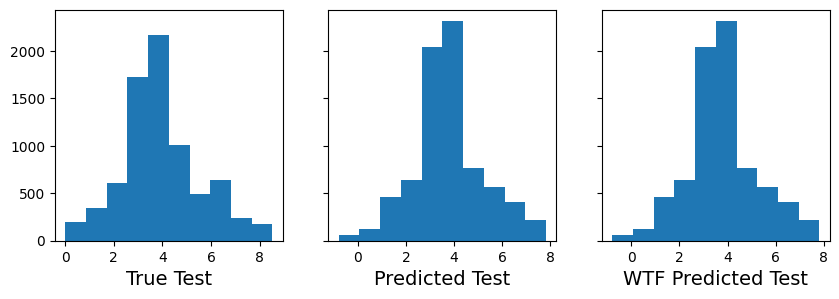

In [269]:
fig, ax = plt.subplots(1, 3, figsize=(10,3), sharey=True)
ax[0].hist(y_test)
ax[0].set_xlabel('True Test', fontsize=14)
ax[1].hist(Y_pred_test)
ax[1].set_xlabel('Predicted Test', fontsize=14)
ax[2].hist(yt)
ax[2].set_xlabel('WTF Predicted Test', fontsize=14)


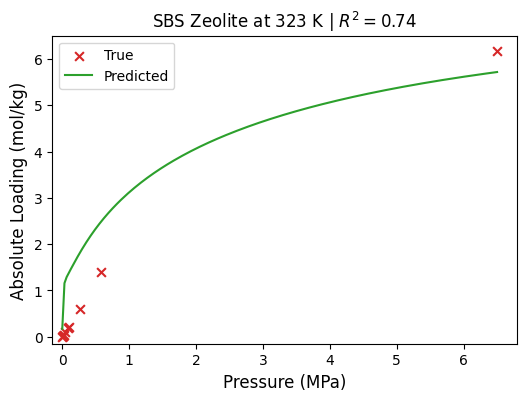

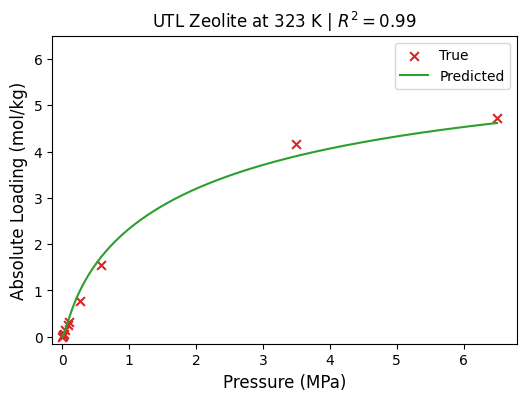

In [298]:
# for _test_z_ in TRAIN_ADSORBENTS:
for _test_z_ in ['SBS', 'UTL']:
    
    try:
        plt.figure(figsize=(6,4), dpi=100)

        CO2_OG_LOC_STR = '/Users/arijitchakraborty/Desktop/Zeolite w:TAMU/CO2.xlsx'
        CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_test_z_)

        plt.scatter(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']/1e6,
                   CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Absolute Loading (mol/kg)'],
                           c='tab:red', label='True', marker='x', s=40)

        min_p = min(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)'])
        max_p = max(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)'])
        p_range = np.linspace(min_p, max_p, 200)
        predictions = [predict_for_zeolite_323(p, list(_DATA_REINDEXED.loc[_test_z_])) for p in p_range]

        plt.plot(p_range/1e6, predictions, label='Predicted', c='tab:green')
        plt.ylabel('Absolute Loading (mol/kg)', fontsize=12)
        plt.xlabel('Pressure (MPa)', fontsize=12)
        plt.title(r'{:s} Zeolite at 323 K | $R^{:d}={:.2f}$'.format(_test_z_,2, r2_score(
                    CO2_temp_adsorbent_data[CO2_temp_adsorbent_data['Temperature (K)']==323][
                        'Absolute Loading (mol/kg)'], [predict_for_zeolite(p, list(
                            _DATA_REINDEXED.loc[_test_z_])) for p in CO2_temp_adsorbent_data[
                                CO2_temp_adsorbent_data['Temperature (K)']==323]['Pressure (Pa)']])))
        plt.ylim(-0.15,6.5)
        plt.xlim(-0.15, 6.8)
        plt.legend()
        plt.savefig('GOOD_TEST_{}_323K.png'.format(_test_z_), dpi=150)
        plt.show()
    except:
        print(_test_z_)


In [271]:
# fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)


In [276]:
# First, for train
_train_preds_ = []
_train_real_ = []

for _ads_ in TRAIN_ADSORBENTS:
    
    CO2_OG_LOC_STR = '/Users/arijitchakraborty/Desktop/Zeolite w:TAMU/CO2.xlsx'
    CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_ads_)
    
    _train_real_.append(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                        'Temperature (K)']==323]['Absolute Loading (mol/kg)'].to_list())
    
    predictions = [predict_for_zeolite_323(p, list(_DATA_REINDEXED.loc[
                        _ads_])) for p in CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                                        'Temperature (K)']==323]['Pressure (Pa)']]
    
    _train_preds_.append(predictions)

def flatten_concatenation(matrix):
    flat_list = []
    for row in matrix:
        flat_list += row
    return flat_list

train_preds = np.array(flatten_concatenation(_train_preds_))
train_real = np.array(flatten_concatenation(_train_real_))

new_train_preds = np.delete(train_preds, np.argwhere(np.isnan(train_preds)))
new_train_real = np.delete(train_real, np.argwhere(np.isnan(train_preds)))


In [277]:
r2_score(new_train_real, new_train_preds)


0.6508133651003049

In [278]:
# Second, for test
_test_preds_ = []
_test_real_ = []

for _ads_ in TEST_ADSORBENTS:
    
    CO2_OG_LOC_STR = '/Users/arijitchakraborty/Desktop/Zeolite w:TAMU/CO2.xlsx'
    CO2_temp_adsorbent_data = pd.read_excel(CO2_OG_LOC_STR, sheet_name=_ads_)
    
    _test_real_.append(CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                        'Temperature (K)']==323]['Absolute Loading (mol/kg)'].to_list())
    
    predictions = [predict_for_zeolite_323(p, list(_DATA_REINDEXED.loc[
                        _ads_])) for p in CO2_temp_adsorbent_data[CO2_temp_adsorbent_data[
                                        'Temperature (K)']==323]['Pressure (Pa)']]
    
    _test_preds_.append(predictions)

def flatten_concatenation(matrix):
    flat_list = []
    for row in matrix:
        flat_list += row
    return flat_list

test_preds = np.array(flatten_concatenation(_test_preds_))
test_real = np.array(flatten_concatenation(_test_real_))

new_test_preds = np.delete(test_preds, np.argwhere(np.isnan(test_preds)))
new_test_real = np.delete(test_real, np.argwhere(np.isnan(test_preds)))


In [279]:
r2_score(new_test_real, new_test_preds)


0.8748683096138659